<a href="https://www.kaggle.com/code/yasinsoylu123/amazon-sock-time-series-stats-and-lstm-model?scriptVersionId=124244993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Time Series Project: Amazon Stock Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Plotting
%matplotlib inline
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot")


from statsmodels.tsa.seasonal import seasonal_decompose #Describes the time data
from statsmodels.tsa.stattools import adfuller #Check if data is stationary
from statsmodels.graphics.tsaplots import plot_acf #Compute lag for ARIMA
from statsmodels.graphics.tsaplots import plot_pacf #Compute partial lag for ARIMA
from statsmodels.tsa.arima_model import ARIMA #Predictions and Forecasting


from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("../input/amazon-stock-price-1997-to-2020/Amazon.csv") 
df.head(10) 

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333,8697600
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208,3472800


---

In [3]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
close_df=df[["Date", "Close"]].copy()

In [5]:
close_df["Date"] = pd.to_datetime(close_df["Date"])
close_df.set_index("Date", inplace = True) 

In [6]:
close_df = close_df.asfreq("d")

In [7]:
close_df.isnull().sum()

Close    2637
dtype: int64

In [8]:
close_df.head()

,Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-17,NaN
1997-05-18,NaN
1997-05-19,1.708333


In [9]:
close_df = close_df.fillna(method  = "bfill")

In [10]:
close_df.isnull().sum()

Close    0
dtype: int64

In [11]:
close_df.shape

(8479, 1)

In [12]:
close_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8479 entries, 1997-05-15 to 2020-07-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   8479 non-null   float64
dtypes: float64(1)
memory usage: 132.5 KB


In [13]:
close_df.describe()


,Close
count,8479.000000
mean,372.297166
std,584.704274
min,1.395833
25%,37.950001
50%,83.050003
75%,359.779999
max,3200.000000


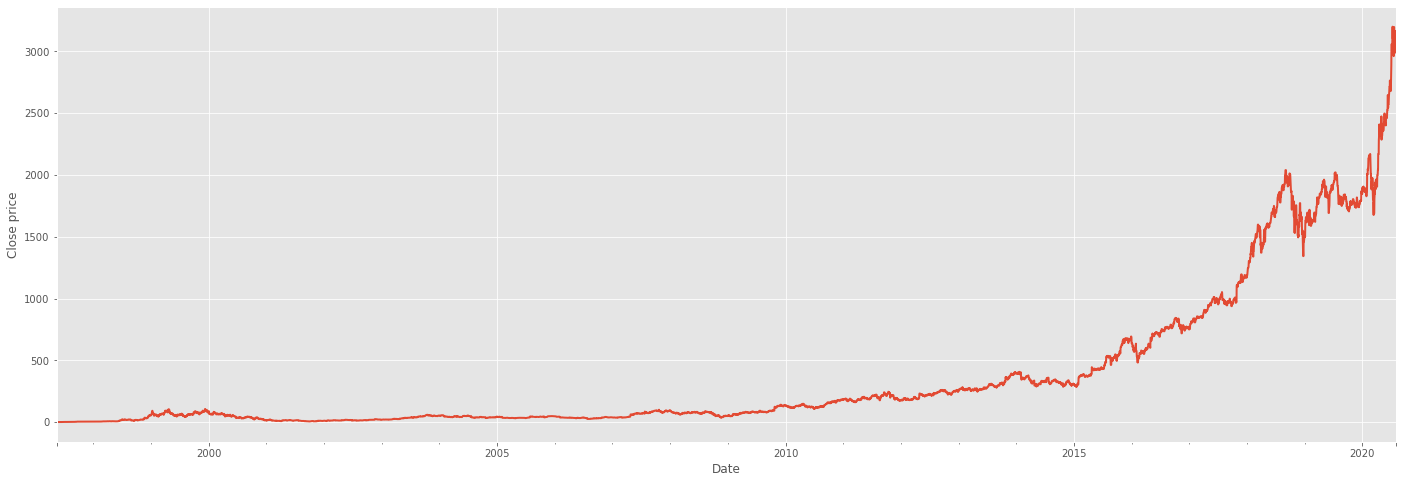

In [14]:
close_df['Close'].plot(figsize=(24,8))
plt.ylabel("Close price")
plt.grid(True)


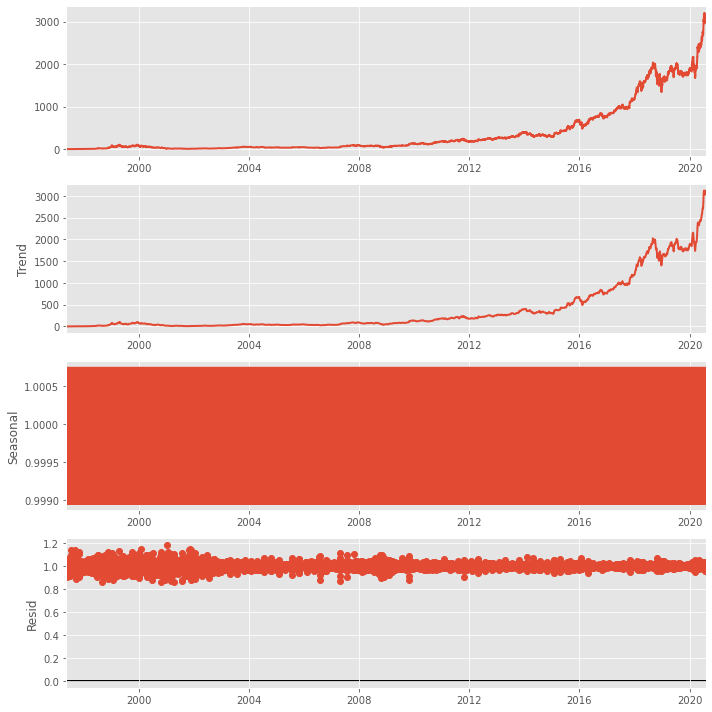

In [15]:
decomp = seasonal_decompose(close_df, model = "multiplicative") #Decompose the data
x = decomp.plot()

In [16]:
adf = adfuller(close_df["Close"])
adf

(5.773923749756863,
 1.0,
 36,
 8442,
 {'1%': -3.431124850687746,
  '5%': -2.8618824309525883,
  '10%': -2.5669522711136055},
 65240.841447642)

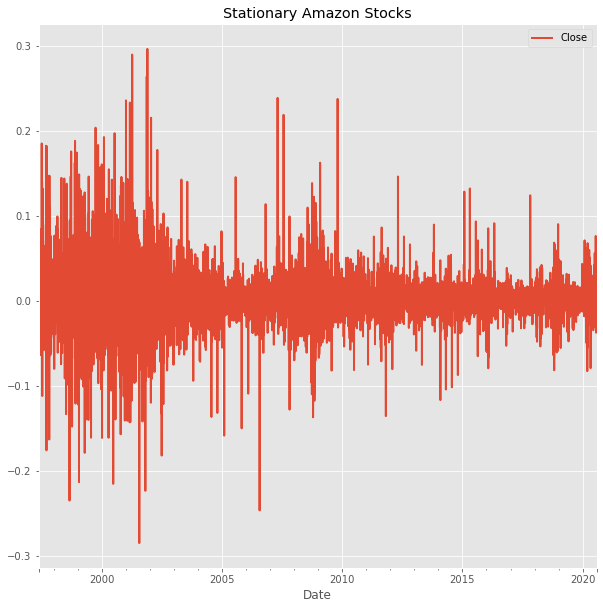

In [17]:
closeLog = np.log(close_df) 
closeStationary = closeLog -closeLog.shift() 
closeStationary = closeStationary.dropna() 
closeStationary.plot(title = "Stationary Amazon Stocks")

In [18]:
adf = adfuller(closeStationary["Close"])
adf

(-46.844760606239475,
 0.0,
 3,
 8474,
 {'1%': -3.4311219237655033,
  '5%': -2.8618811376213795,
  '10%': -2.566951582662797},
 -35024.481571239216)

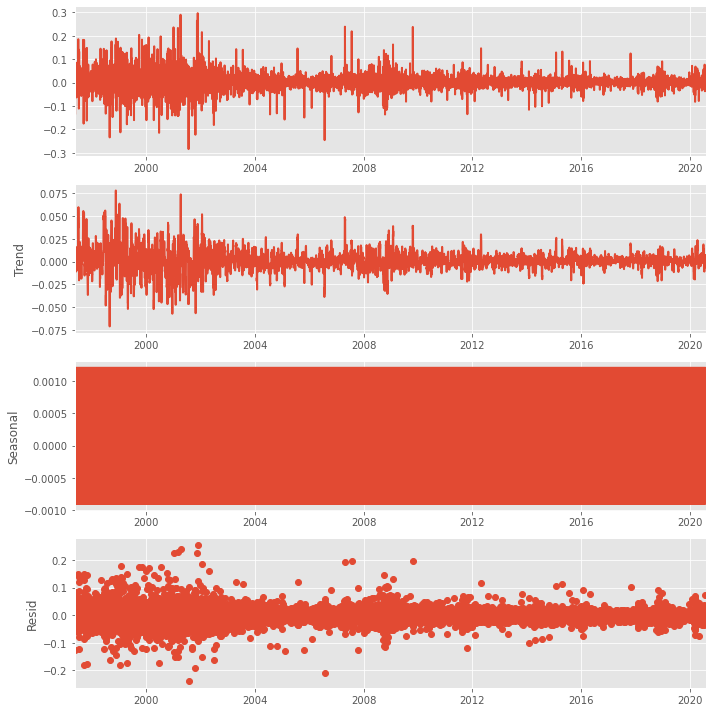

In [19]:
decomp = seasonal_decompose(closeStationary)
x = decomp.plot()

# ARIMA

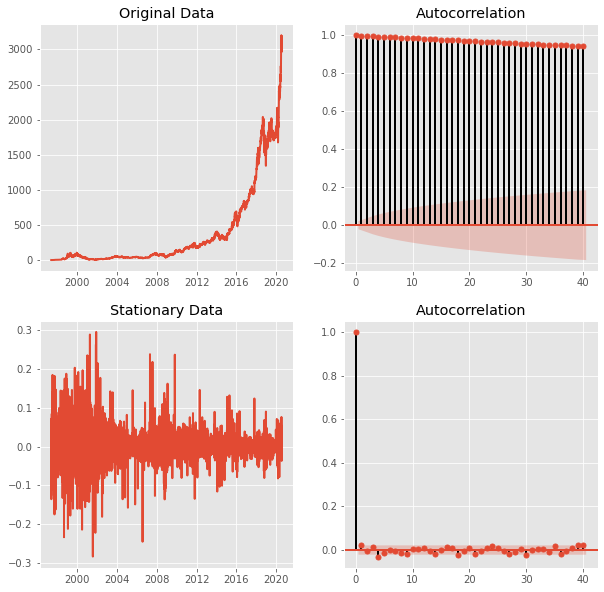

In [20]:
fig,axes = plt.subplots(2,2) 

a = axes[0,0].plot(close_df["Close"]) 
a = axes[0,0].set_title("Original Data") 
b = plot_acf(close_df["Close"],ax=axes[0,1]) 

x = axes[1,0].plot(closeStationary["Close"])
x = axes[1,0].set_title("Stationary Data") 
y = plot_acf(closeStationary["Close"],ax=axes[1,1]) 

# AR Lag

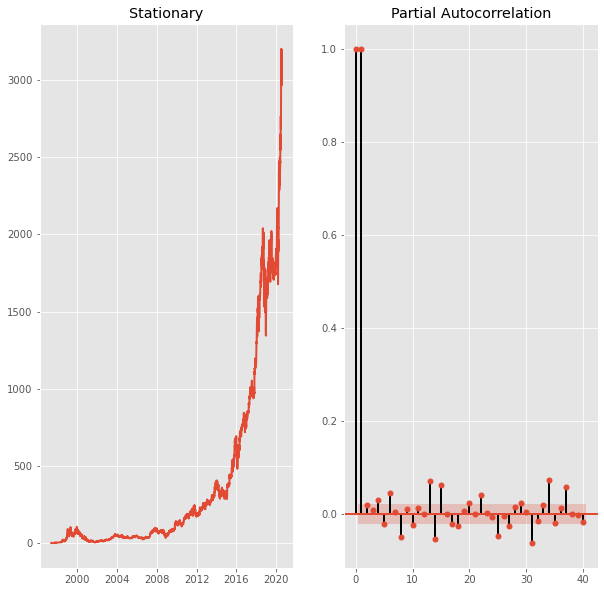

In [21]:
fig,axes = plt.subplots(1,2) 

a = axes[0].plot(close_df["Close"]) 
a = axes[0].set_title("Stationary") 
b = plot_pacf(close_df["Close"], ax = axes[1], method = "ols") 

# MA Lag

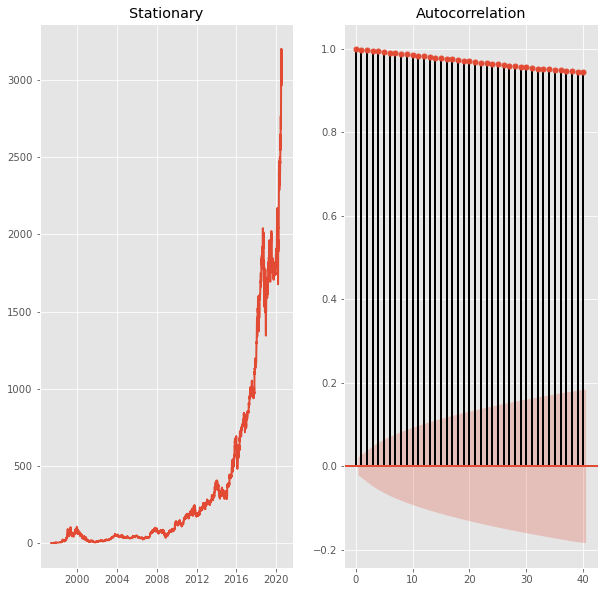

In [22]:
fig,axes = plt.subplots(1,2) 

a = axes[0].plot(close_df["Close"])
a = axes[0].set_title("Stationary") 
b = plot_acf(close_df["Close"], ax = axes[1]) 

# Train the ARIMA


In [23]:
model = ARIMA(close_df, order = (6, 1, 6)) 
fitModel = model.fit(disp = 1)

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


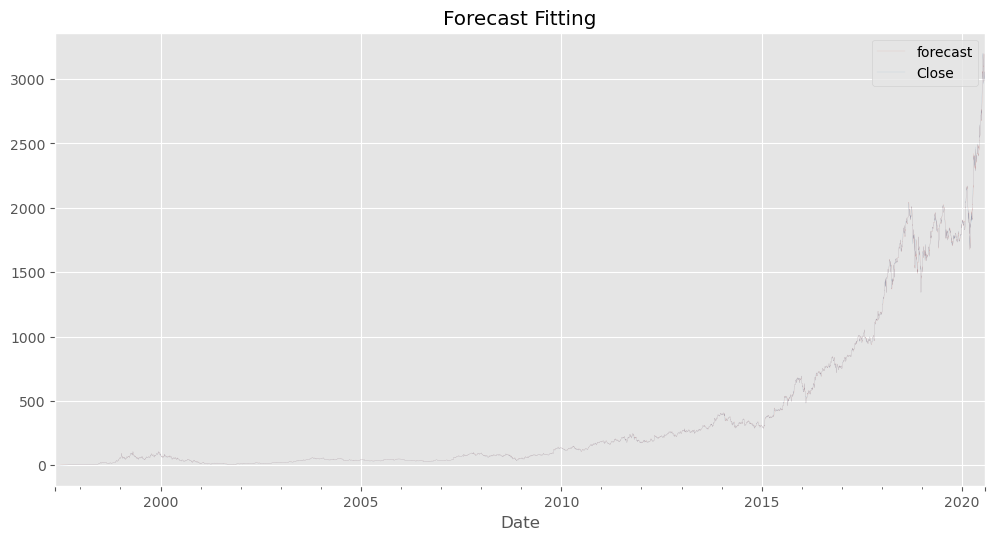

In [24]:
plt.rcParams.update({"figure.figsize" : (12,6), "lines.linewidth" : 0.05, "figure.dpi" : 100}) 

x = fitModel.plot_predict(dynamic = False) 
x = plt.title("Forecast Fitting")
plt.show() 

In [25]:
plt.rcParams.update({"figure.figsize" : (12,5), "lines.linewidth": 2}) 
length = int((len(close_df)*9)/10) 
print(length)

7631


In [26]:
train = close_df[:length] 
test = close_df[length:] 
modelValid = ARIMA(train,order=(5,1,5)) 
fitModelValid = modelValid.fit(disp= -1) 

In [27]:
fc,se,conf = fitModelValid.forecast(len(close_df) - length) 
forecast = pd.Series(fc, index = test.index)

Text(0, 0.5, 'close Price')

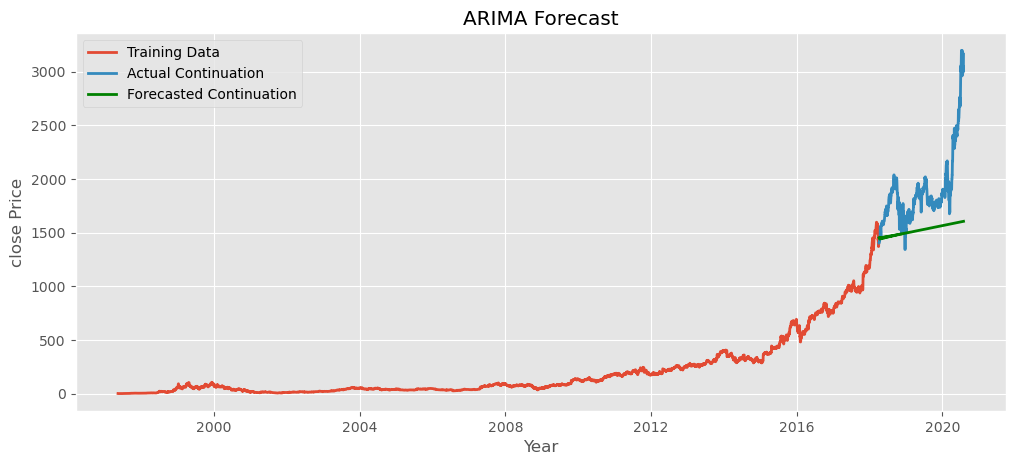

In [28]:

plt.plot(train,label = "Training Data") 
plt.plot(test,label = "Actual Continuation")
plt.plot(forecast,label = "Forecasted Continuation", color = "g")

plt.title("ARIMA Forecast")
plt.legend(loc = "upper left") 
plt.xlabel("Year") 
plt.ylabel("close Price")

In [29]:
modelPred = ARIMA(close_df,order=(5,1,5)) 
fitModelPred = modelPred.fit(disp= -1) 

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


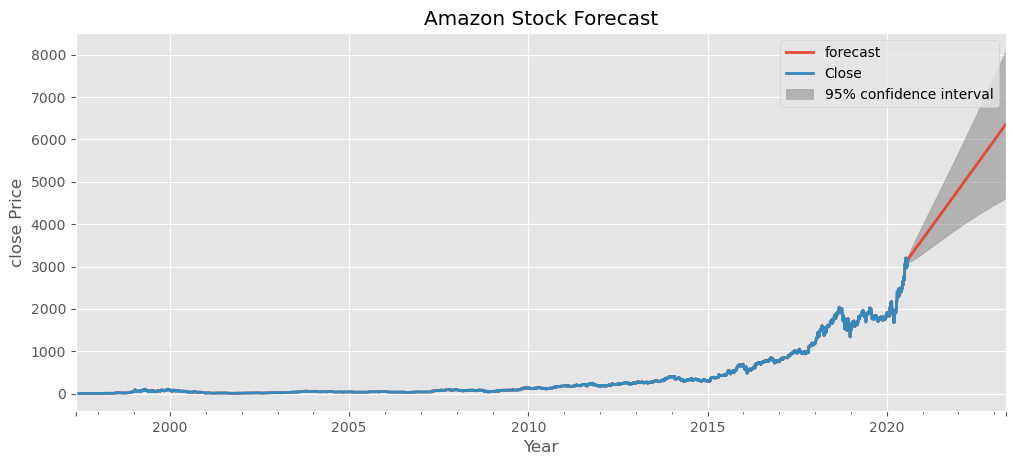

In [30]:
fitModelPred.plot_predict(1,len(close_df) + 1000) 
x = fitModelPred.forecast(1000) 
x = plt.title("Amazon Stock Forecast") 
x = plt.xlabel("Year") 
x = plt.ylabel("close Price") 

# Stats model

In [31]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


In [32]:
df["Date"]=pd.to_datetime(df.Date,dayfirst=True)
df.set_index("Date",inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...
2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100


In [33]:
df=df.asfreq("d")
df = df.fillna(method  = "bfill")

Text(0, 0.5, 'open price')

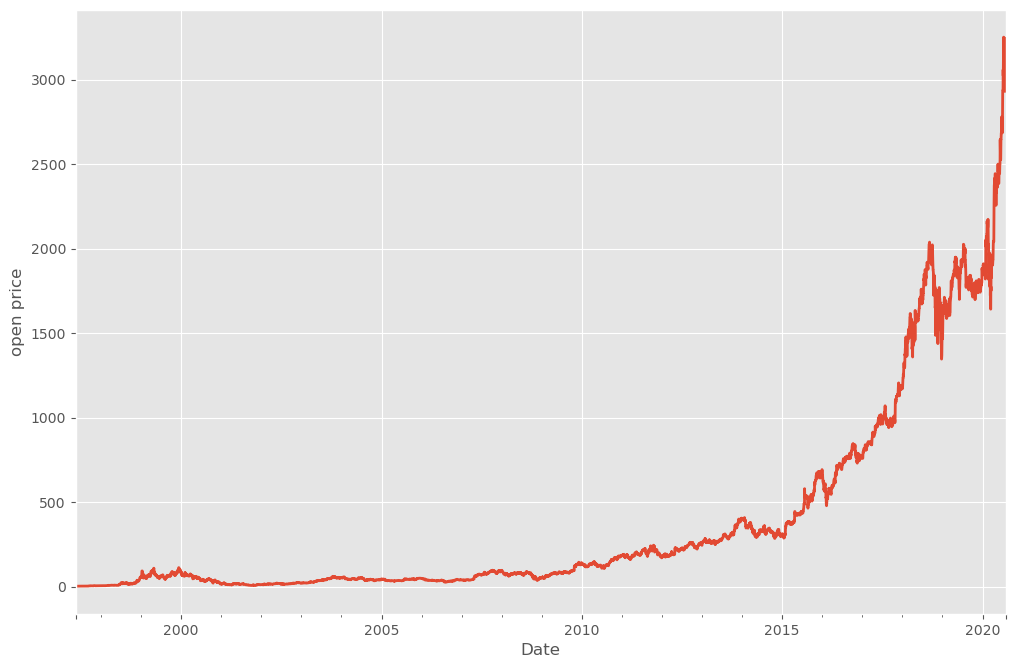

In [34]:
df['Open'].plot(figsize=(12,8))
plt.ylabel("open price")

Text(0, 0.5, 'Volume price')

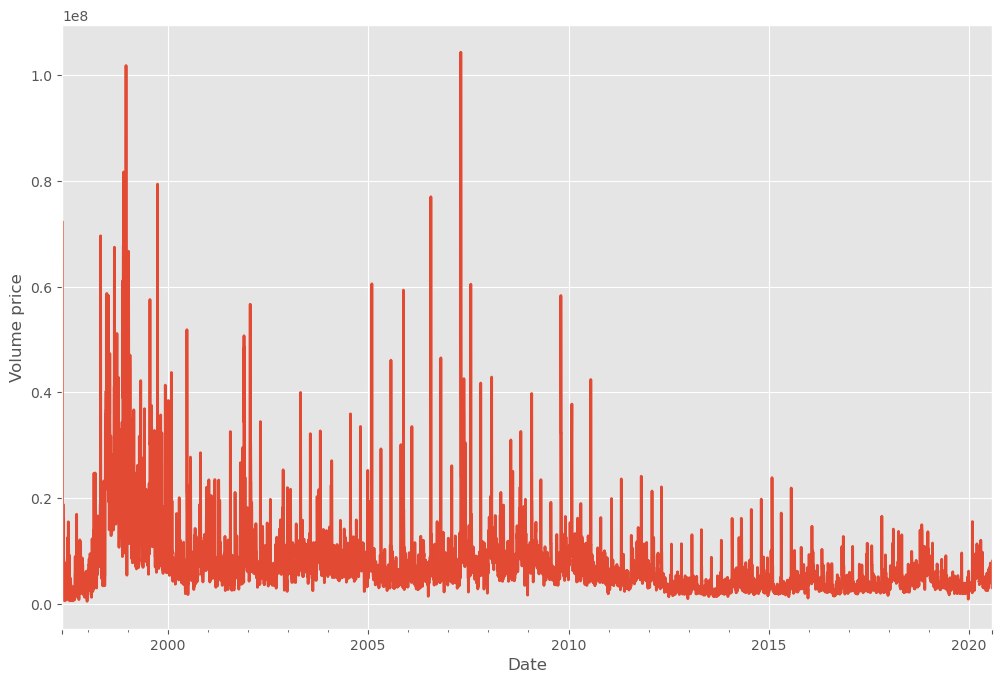

In [35]:
df['Volume'].plot(figsize=(12,8))
plt.ylabel("Volume price")

In [36]:
df['Total Pos'] = df.sum(axis=1)


Text(0.5, 1.0, 'Total Portfolio Value')

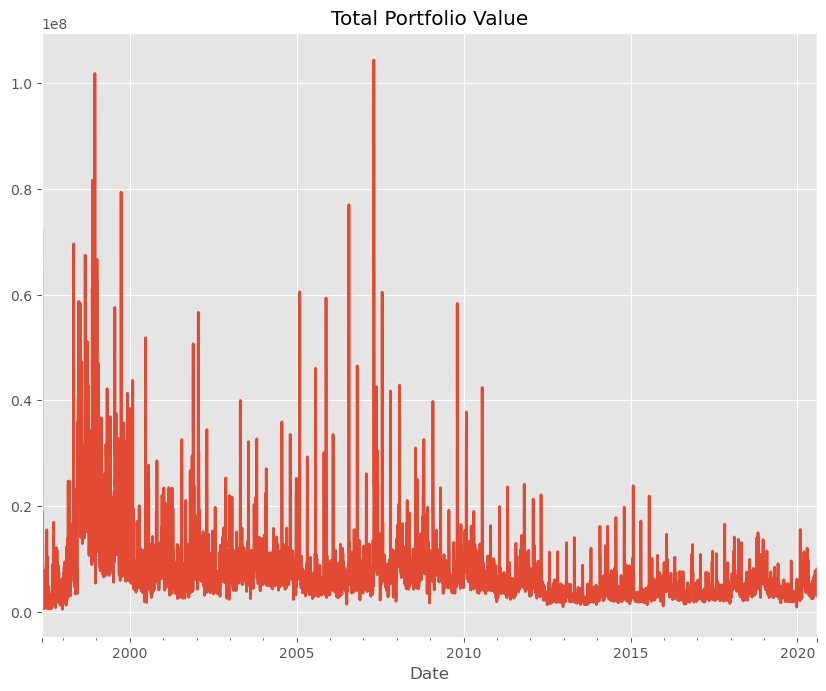

In [37]:
df['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

In [38]:
df['Daily Return'] = df['Total Pos'].pct_change(1)


In [39]:
df['Daily Return'].mean()


0.06823123939588155

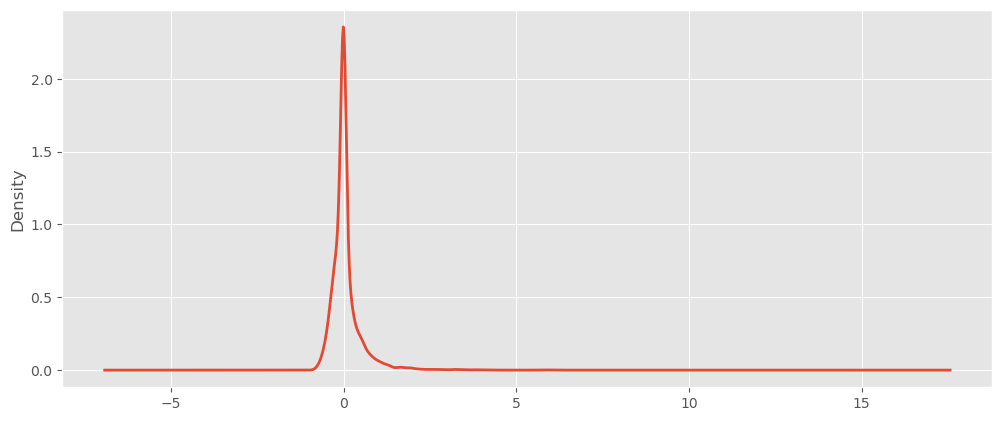

In [40]:
df['Daily Return'].plot(kind='kde')


In [41]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()


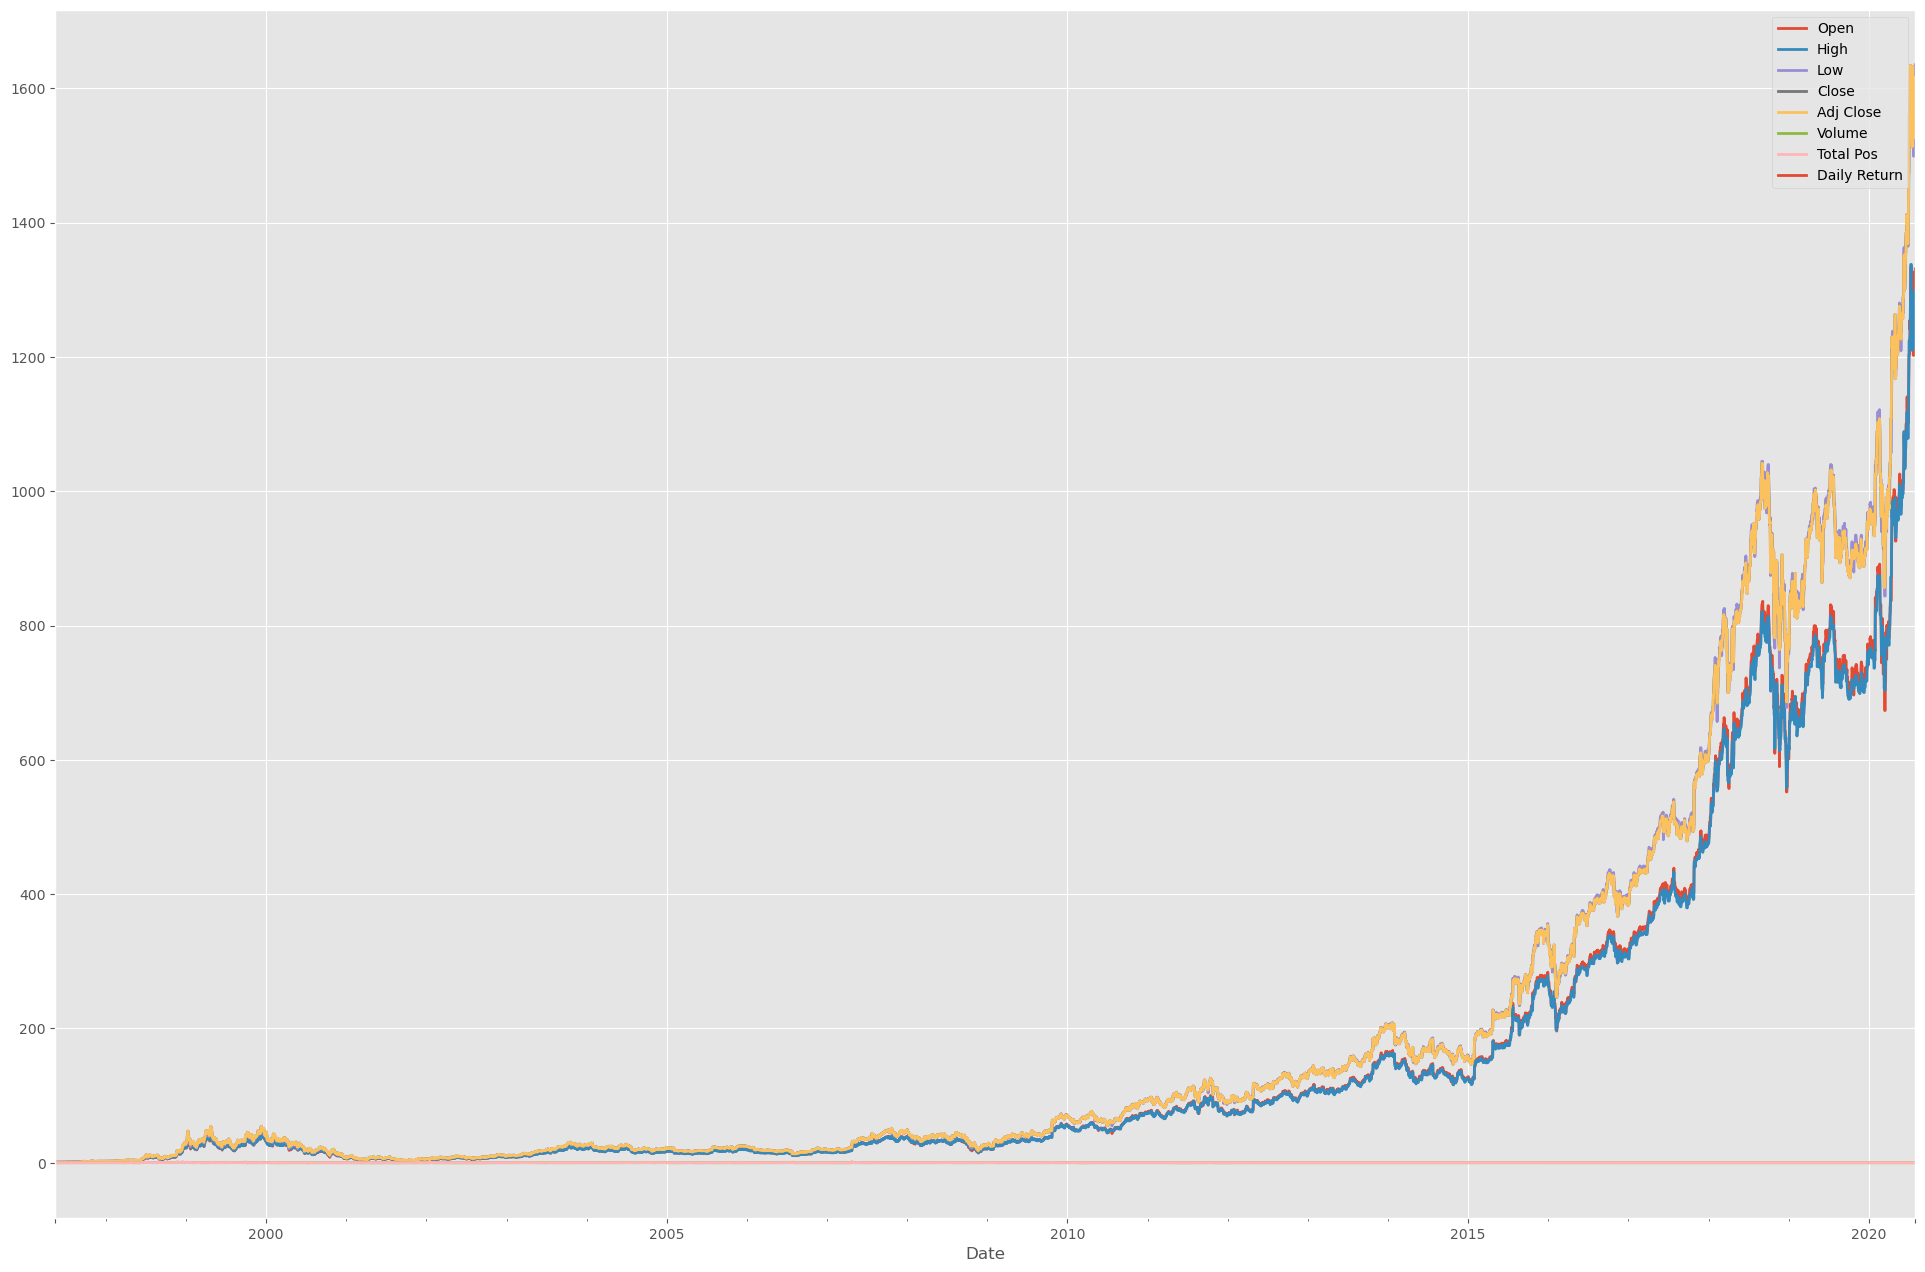

In [42]:
all_plot = df/df.iloc[0]
all_plot.plot(figsize=(24,16))

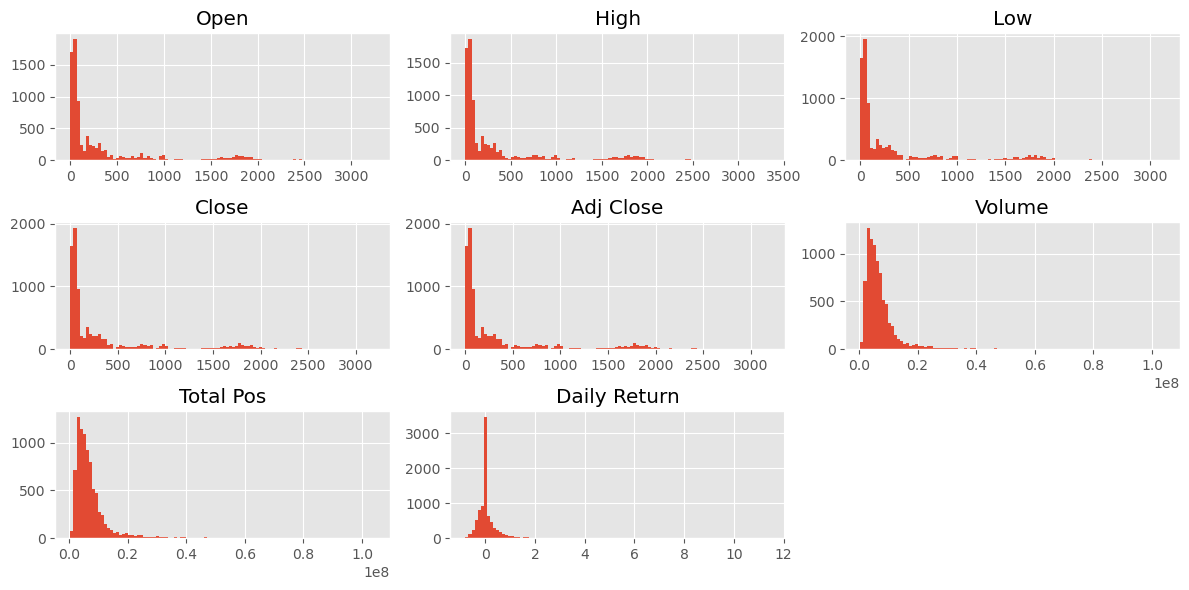

In [43]:
df.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [44]:
df.resample(rule='A').mean()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return
Date,,,,,,,,
1997-12-31,3.106173,3.224387,3.001646,3.118213,3.118213,4.171797e+06,4.171813e+06,0.189911
1998-12-31,15.549329,16.260688,15.011722,15.716271,15.716271,2.002507e+07,2.002515e+07,0.123226
1999-12-31,69.500592,72.031949,66.374743,69.024786,69.024786,1.654916e+07,1.654951e+07,0.074769
2000-12-31,46.450350,48.361808,44.470458,46.441129,46.441129,8.518387e+06,8.518619e+06,0.092401
2001-12-31,12.244265,12.708774,11.694534,12.166885,12.166885,8.416041e+06,8.416102e+06,0.122944
2002-12-31,16.417397,16.937644,16.028603,16.498384,16.498384,8.665755e+06,8.665837e+06,0.084069
2003-12-31,37.489562,38.214137,36.894137,37.686274,37.686274,8.859705e+06,8.859893e+06,0.052733
2004-12-31,43.642896,44.429918,42.925519,43.686202,43.686202,8.399211e+06,8.399429e+06,0.060031
2005-12-31,39.820713,40.437562,39.439562,39.970055,39.970055,6.822992e+06,6.823192e+06,0.093089


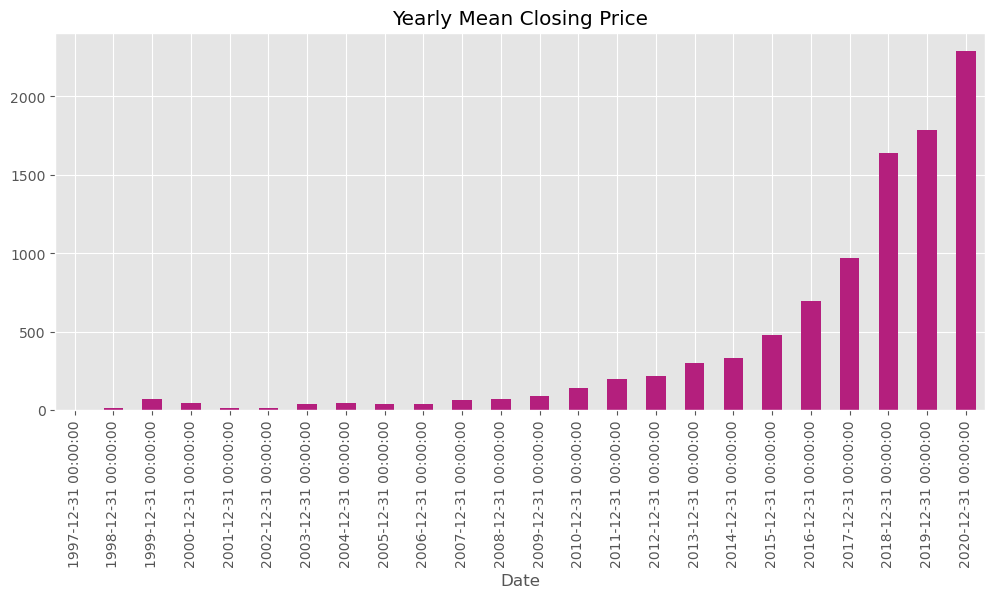

In [45]:
title = 'Yearly Mean Closing Price'
df['Open'].resample('A').mean().plot.bar(title=title,color=['#b41f7d']);

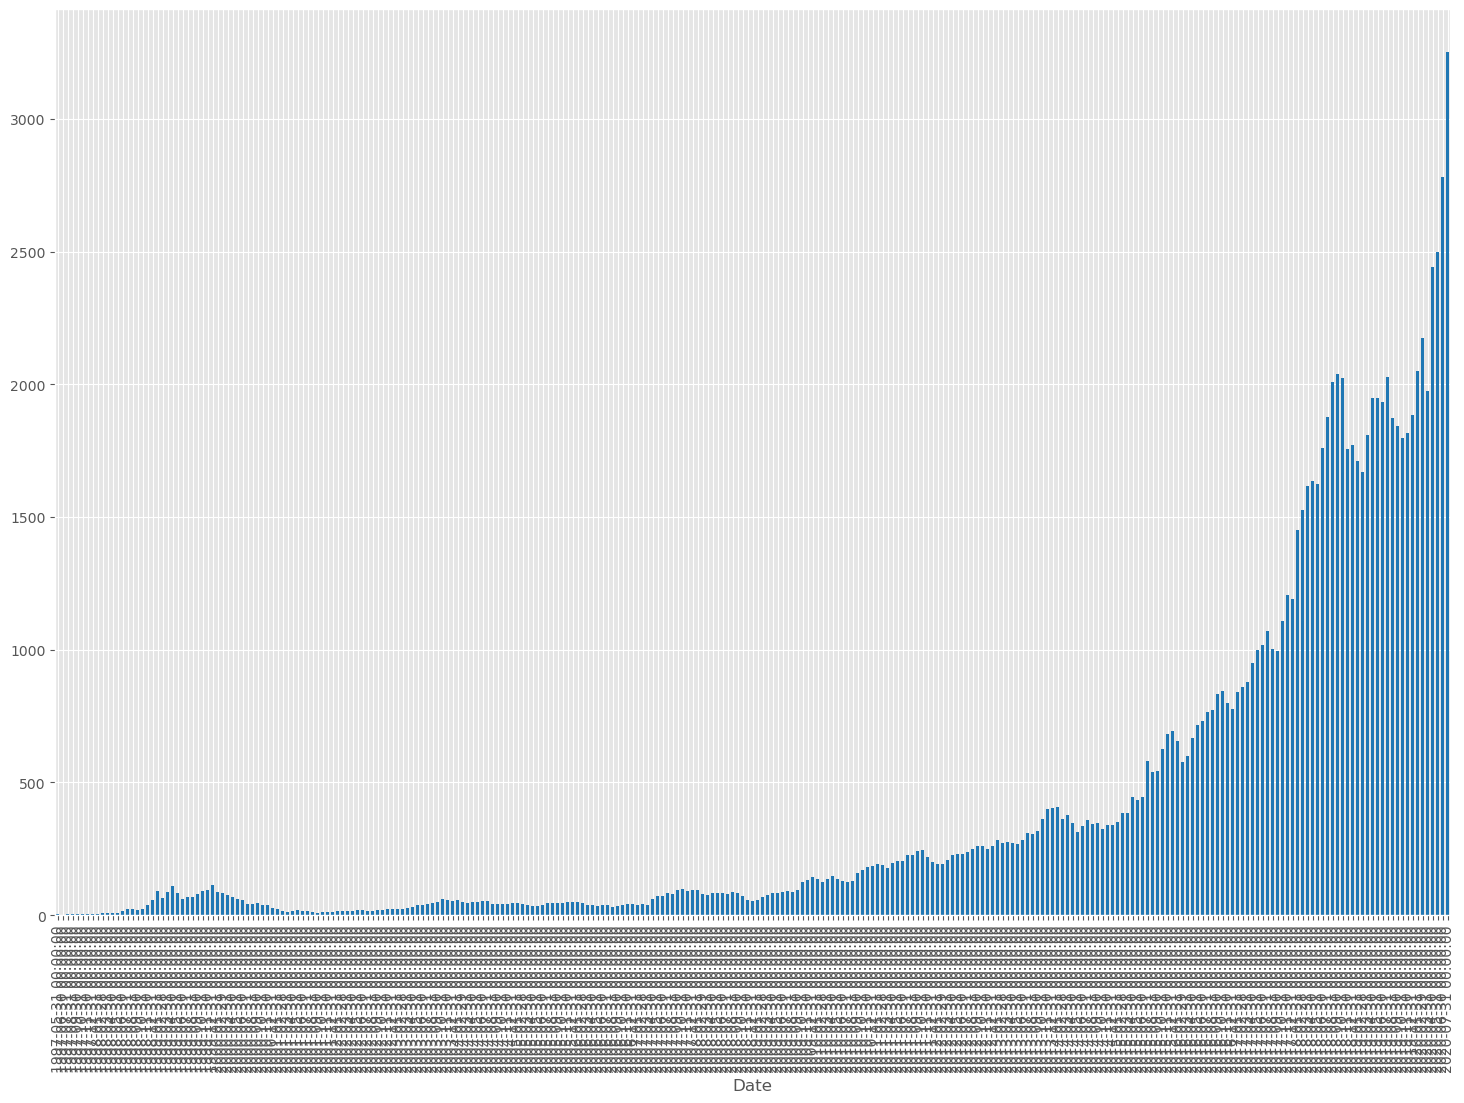

In [46]:
df['Open'].resample('M').max().plot.bar(figsize=(18,12),color='#1f77b4');


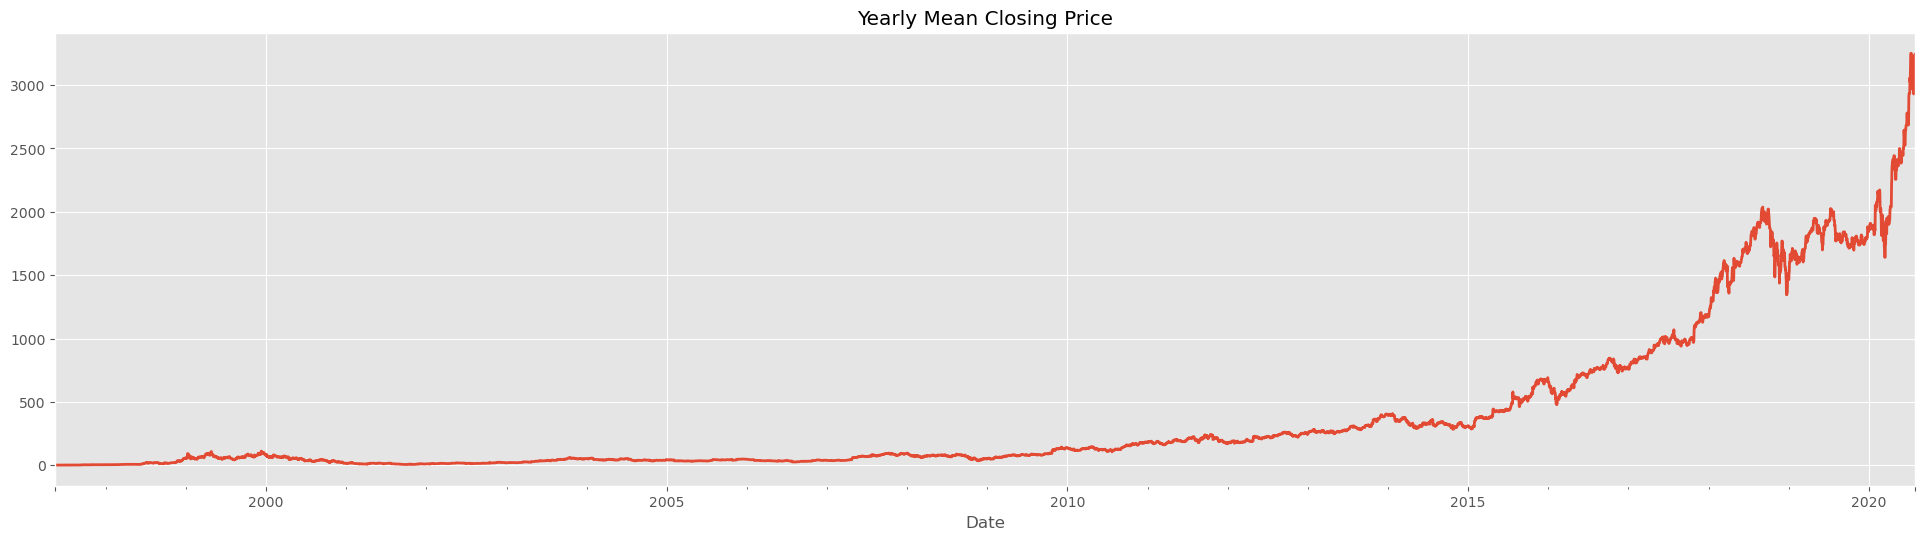

In [47]:
ax = df['Open'].plot(figsize=(24,6),title=title)


In [48]:
df['6-month-SMA'] = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA'] = df['Open'].rolling(window=2).mean()

In [49]:
df.head(13)


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA
Date,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0,7.215601e+07,NaN,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0,1.470001e+07,-0.796275,NaN,NaN,2.203125
1997-05-17,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,-0.584571,NaN,NaN,1.864583
1997-05-18,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200.0,5.467208e+06,-0.104736,1.902778,NaN,1.744792
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200.0,1.885321e+07,2.448416,1.769097,NaN,1.682292
1997-05-22,1.437500,1.447917,1.312500,1.395833,1.395833,11776800.0,1.177681e+07,-0.375342,1.680556,NaN,1.536458
1997-05-23,1.406250,1.520833,1.333333,1.500000,1.500000,15937200.0,1.593721e+07,0.353271,1.621528,NaN,1.421875


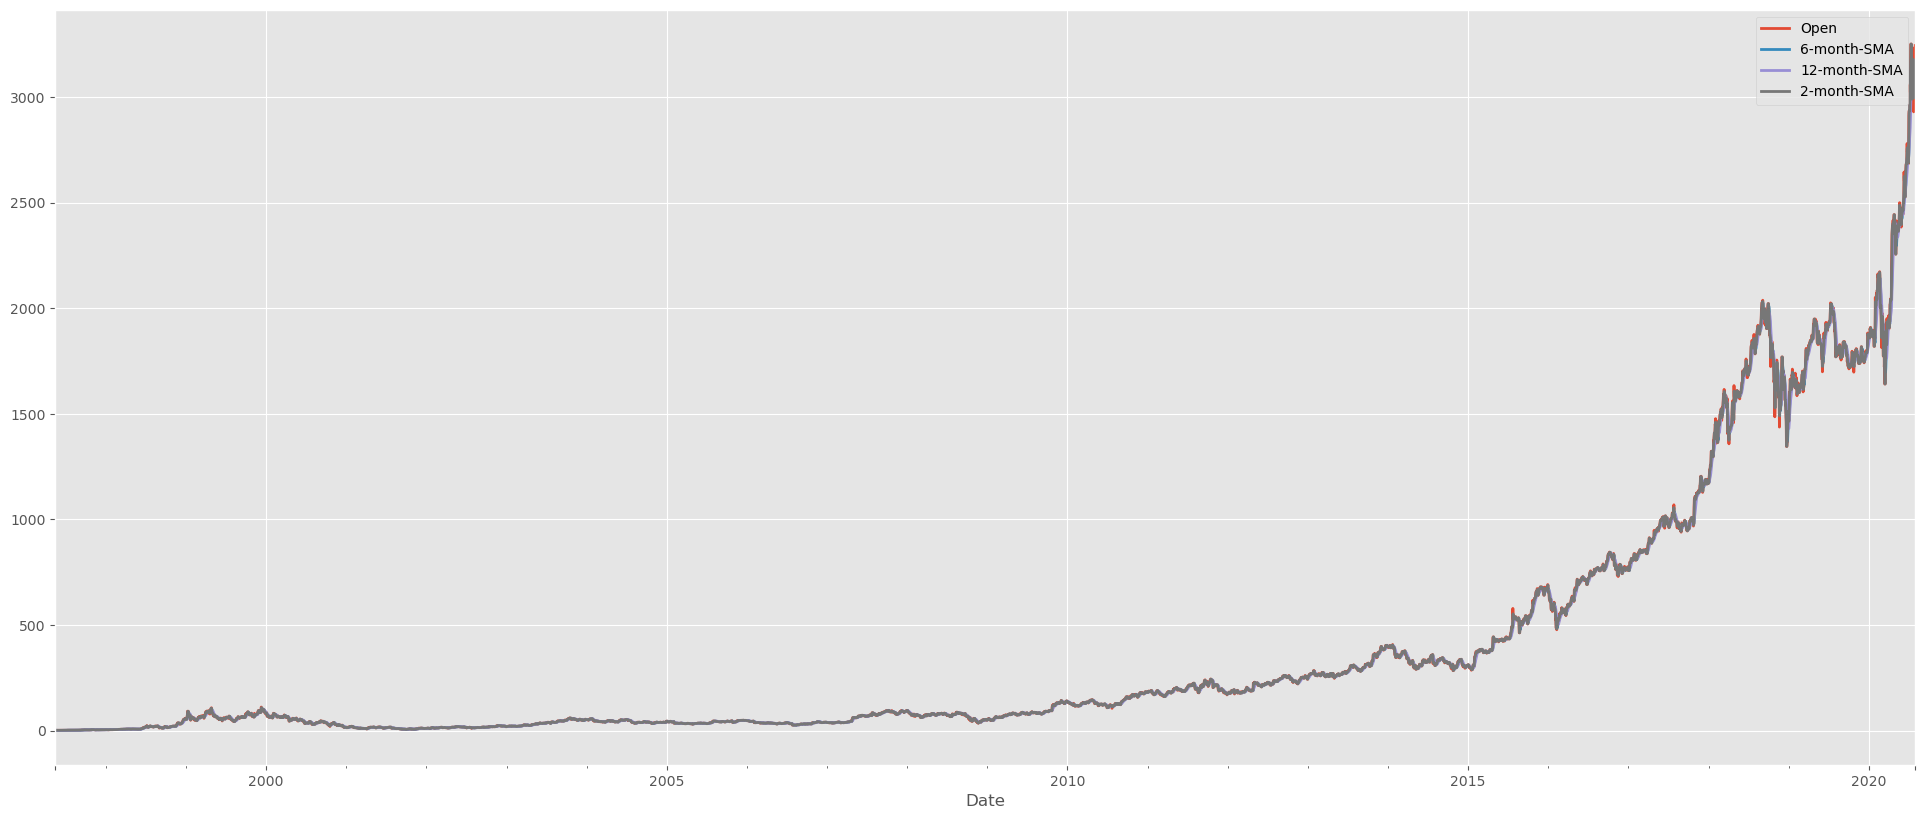

In [50]:
df[["Open","6-month-SMA","12-month-SMA","2-month-SMA"]].plot(figsize=(24,10));


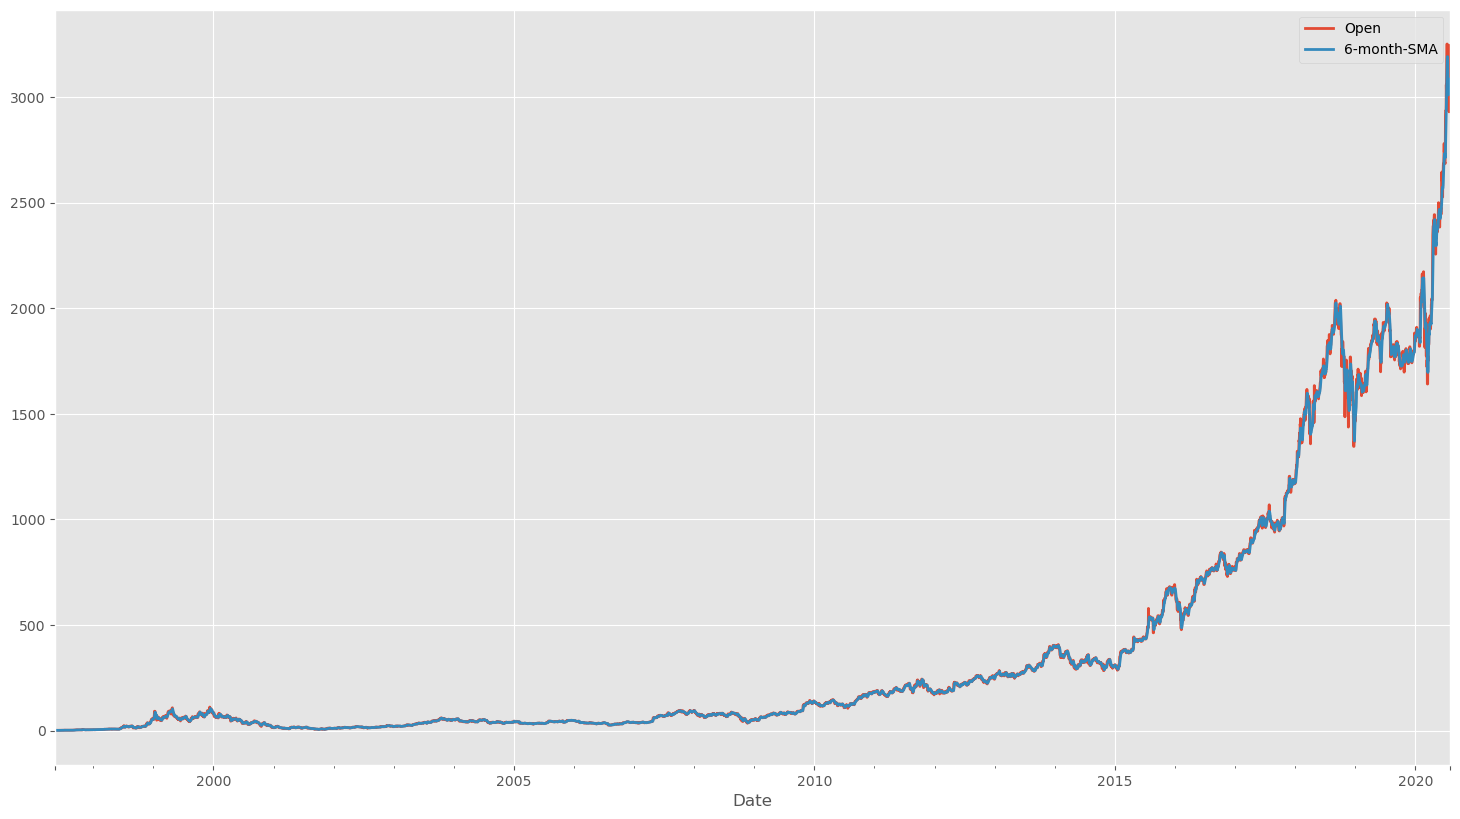

In [51]:
df[["Open","6-month-SMA"]].plot(figsize=(18,10));


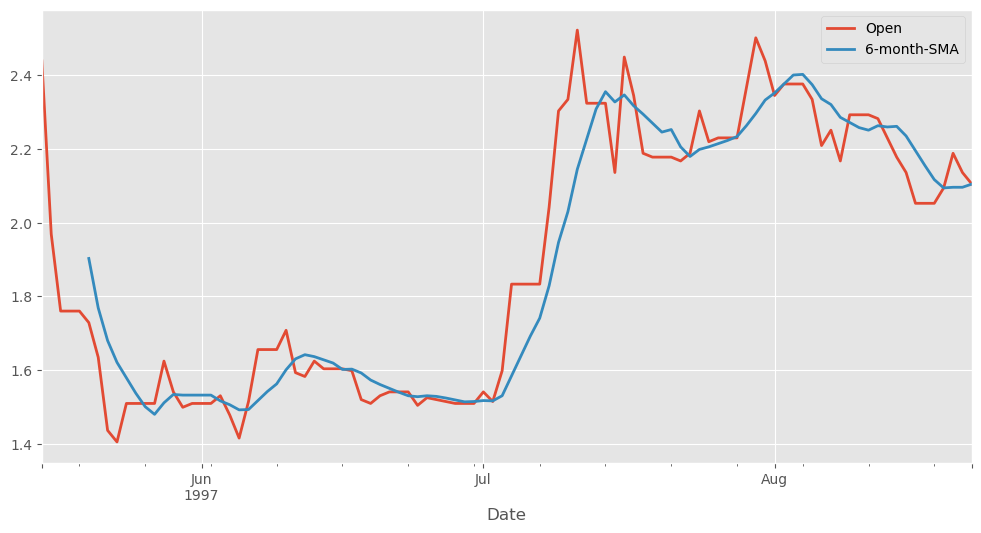

In [52]:
df[['Open','6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [53]:
df['EWMA12'] = df['Open'].ewm(span=14,adjust=True).mean()


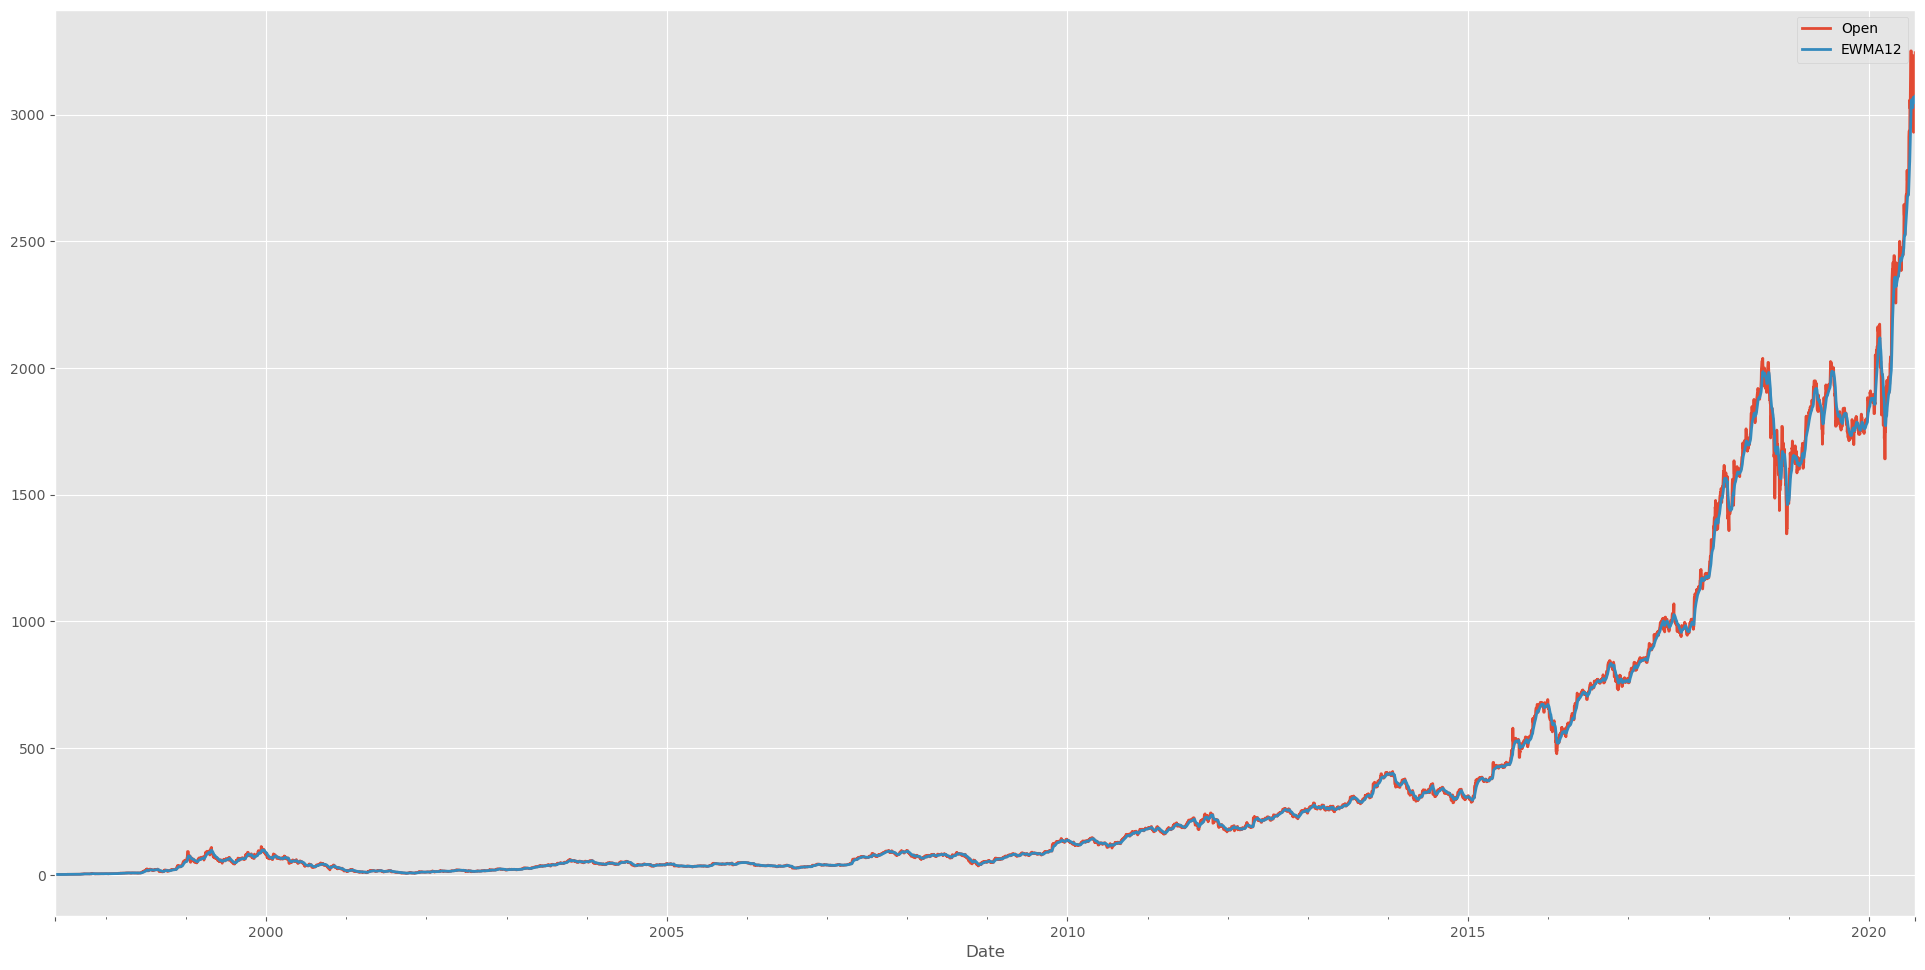

In [54]:
df[['Open','EWMA12']].plot(figsize=(24,12));

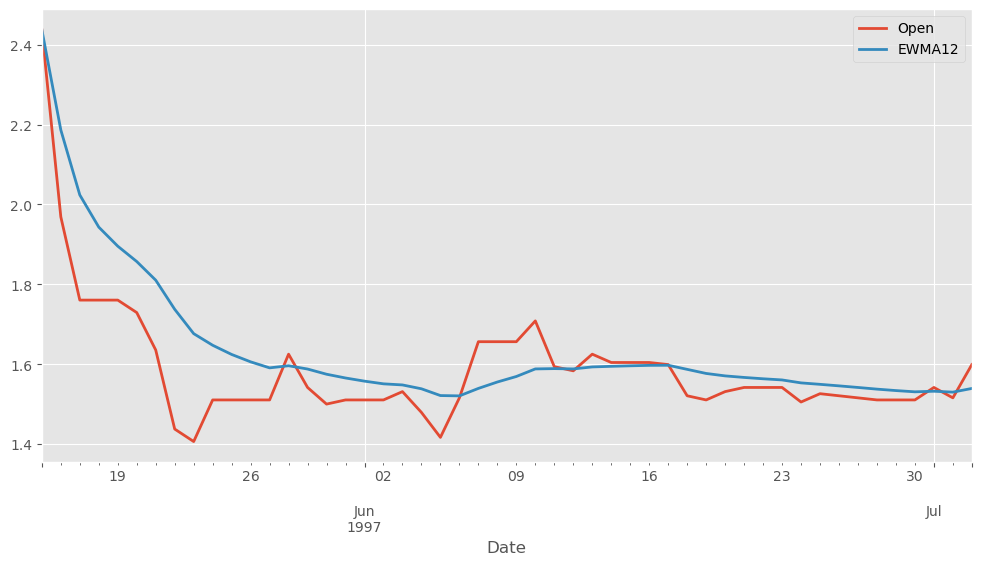

In [55]:
df[['Open','EWMA12']].iloc[:50].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [56]:
df['EWMA12'] = df['Open'].ewm(span=14,adjust=True).mean()


In [57]:
span = 12
alpha = 2/(span+1)

In [58]:
df['EWMA12'] = df['Open'].ewm(alpha=alpha,adjust=False).mean()

In [59]:
model=SimpleExpSmoothing(df["Open"])

In [60]:
model.fit(smoothing_level=alpha,optimized=False)


In [61]:
fitted_model=model.fit(smoothing_level=alpha,optimized=False)


In [62]:
fitted_model.fittedvalues


Date
1997-05-15       2.437500
1997-05-16       2.437500
1997-05-17       2.365385
1997-05-18       2.272313
1997-05-19       2.193559
                 ...     
2020-07-27    3056.673870
2020-07-28    3057.493275
2020-07-29    3056.997389
2020-07-30    3052.996251
2020-07-31    3046.996828
Freq: D, Length: 8479, dtype: float64

In [63]:
fitted_model.fittedvalues.shift(-1)


Date
1997-05-15       2.437500
1997-05-16       2.365385
1997-05-17       2.272313
1997-05-18       2.193559
1997-05-19       2.126922
                 ...     
2020-07-27    3057.493275
2020-07-28    3056.997389
2020-07-29    3052.996251
2020-07-30    3046.996828
2020-07-31            NaN
Freq: D, Length: 8479, dtype: float64

In [64]:
df["SES12"]=fitted_model.fittedvalues.shift(-1)


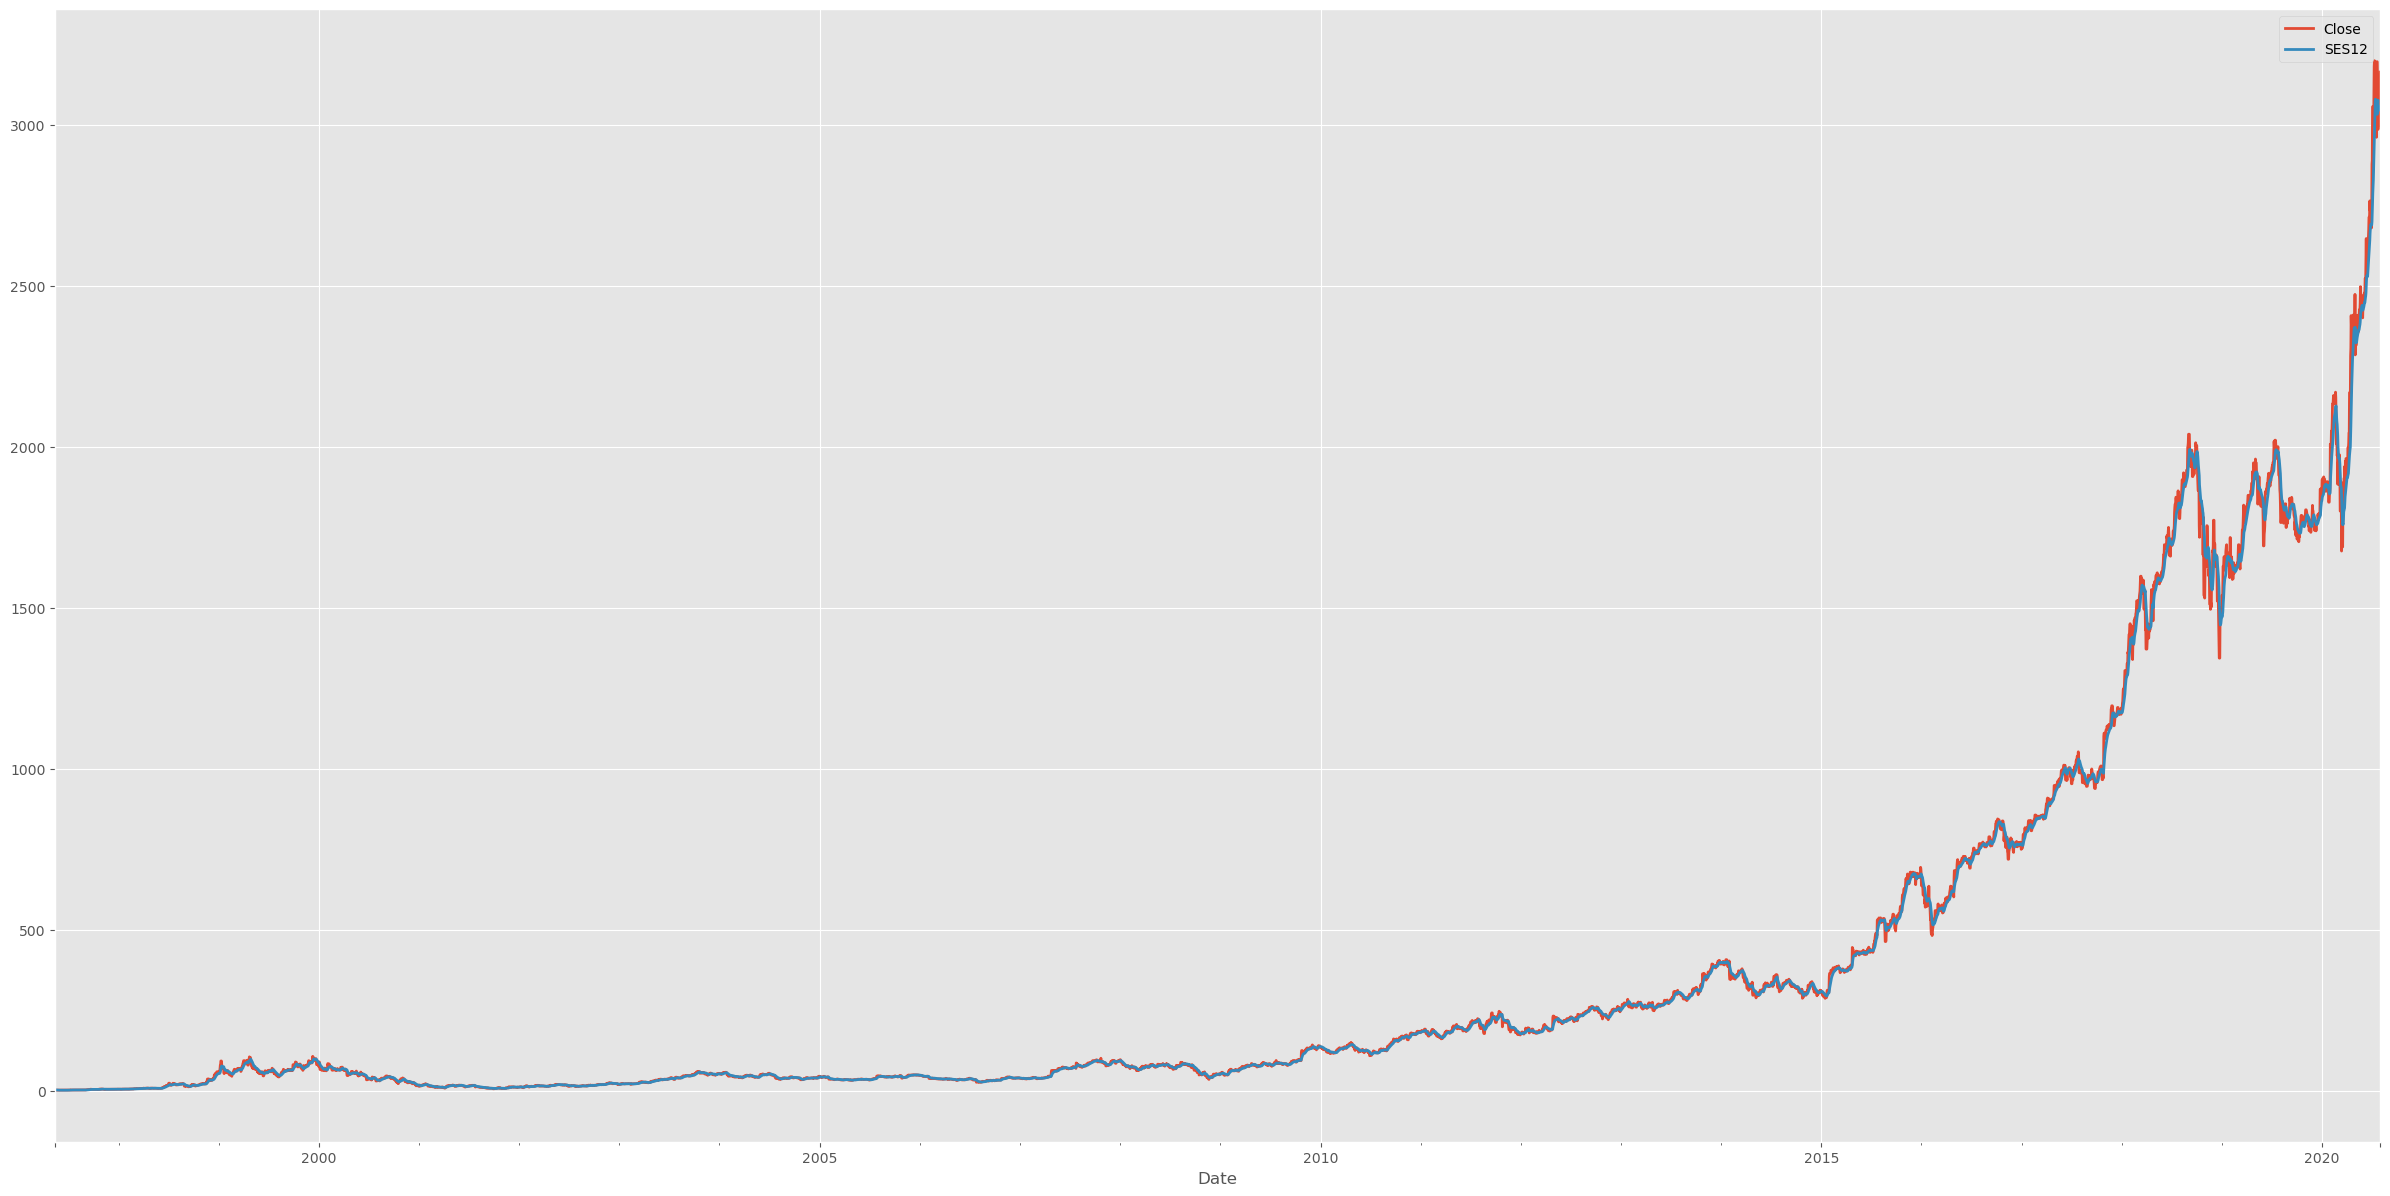

In [65]:
df[['Close',"SES12"]].plot(figsize=(30,15)).autoscale(axis='x',tight=True);


In [66]:
df['DESadd12'] = ExponentialSmoothing(df['Open'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12
Date,,,,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0,7.215601e+07,NaN,NaN,NaN,NaN,2.437500,2.437500,2.479330
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0,1.470001e+07,-0.796275,NaN,NaN,2.203125,2.365385,2.365385,2.047903
1997-05-17,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,-0.584571,NaN,NaN,1.864583,2.272313,2.272313,1.820880
1997-05-18,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.193559,2.193559,1.802316
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.126922,2.126922,1.800725


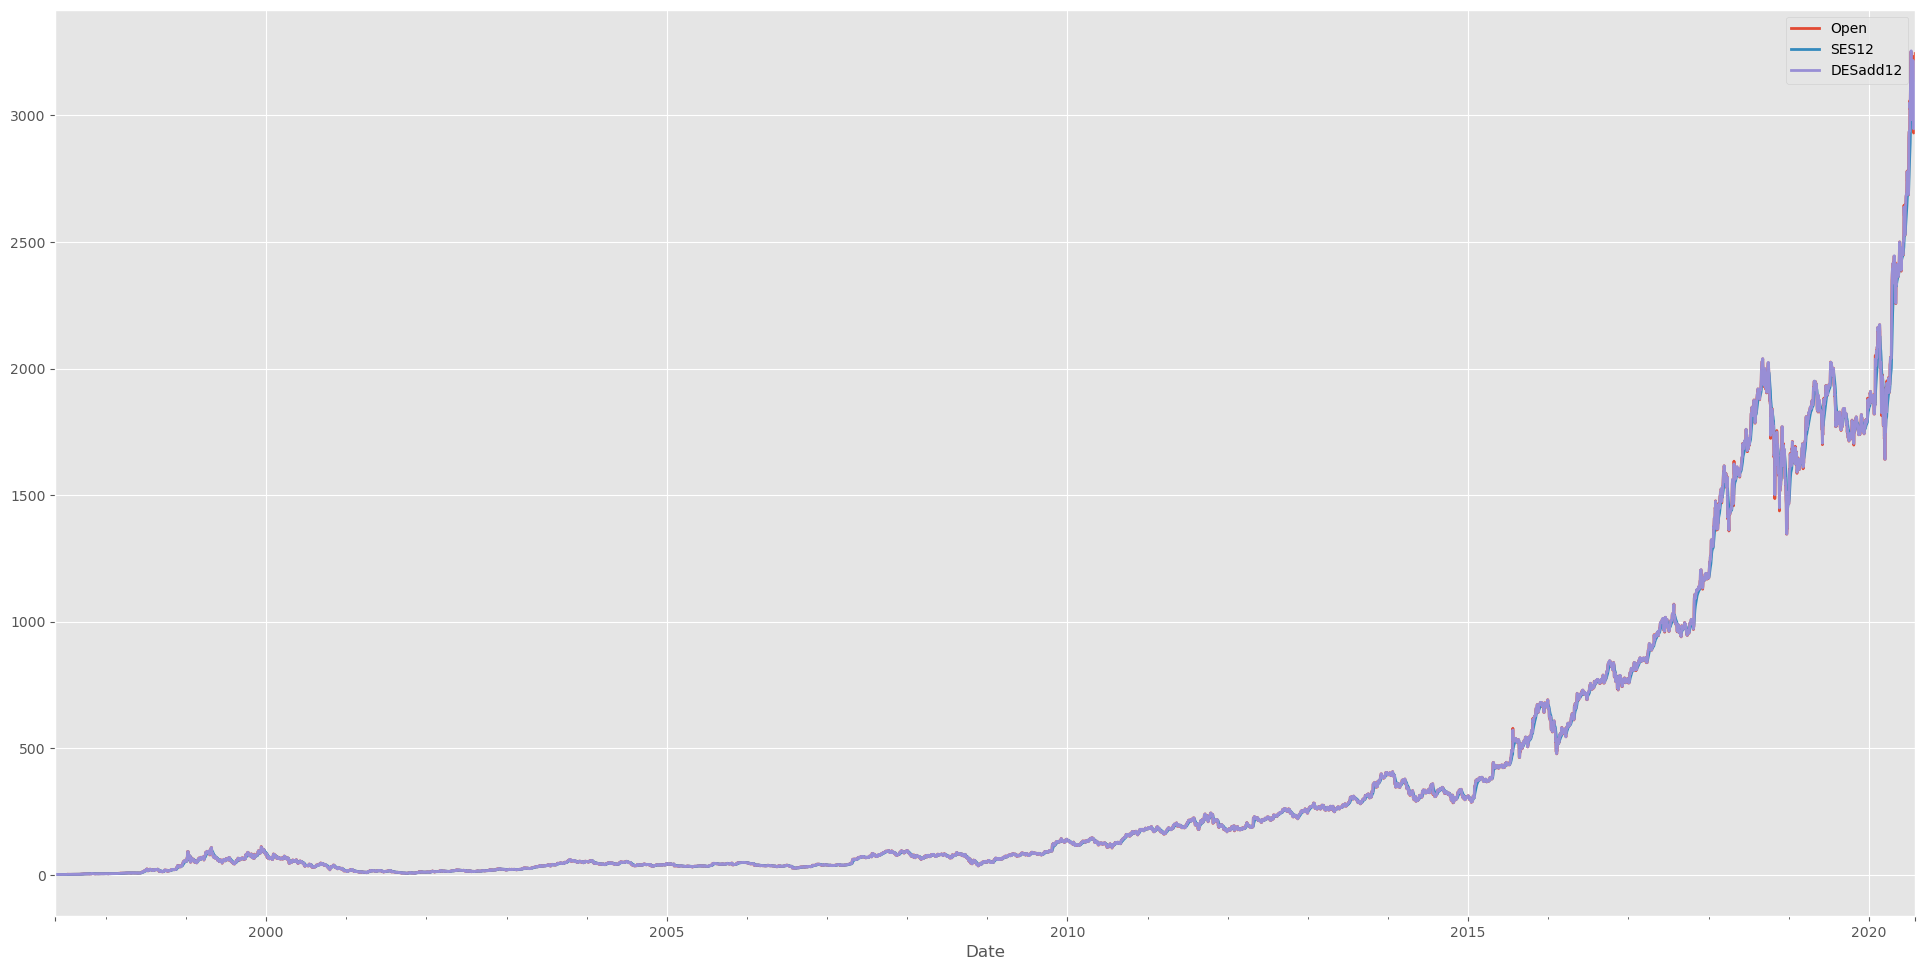

In [67]:
df[['Open',  'SES12', 'DESadd12']].plot(figsize=(24,12))


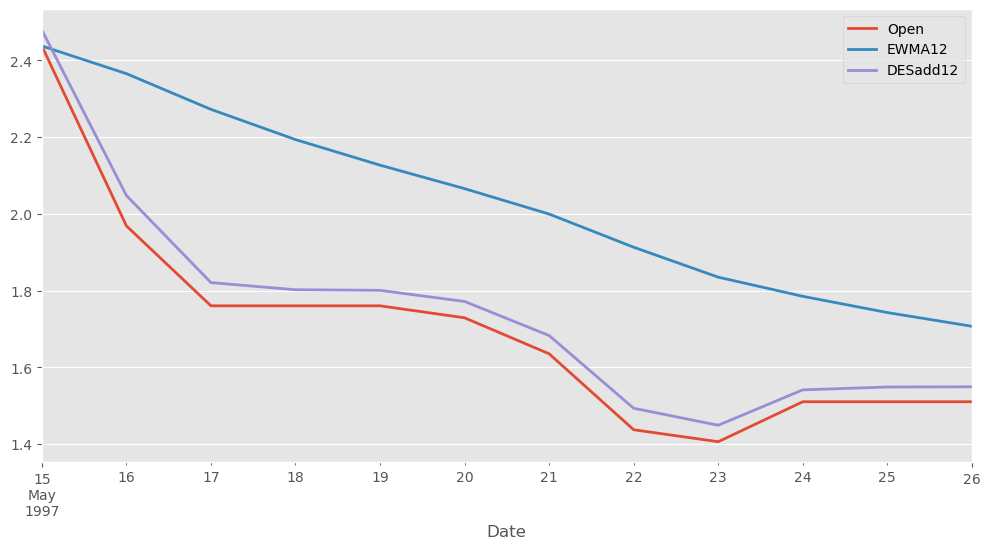

In [68]:
df[['Open','EWMA12','DESadd12']].iloc[:12].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [69]:
df['DESmul12'] = ExponentialSmoothing(df['Open'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Date,,,,,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0,7.215601e+07,NaN,NaN,NaN,NaN,2.437500,2.437500,2.479330,2.454320
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0,1.470001e+07,-0.796275,NaN,NaN,2.203125,2.365385,2.365385,2.047903,2.010818
1997-05-17,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,-0.584571,NaN,NaN,1.864583,2.272313,2.272313,1.820880,1.782960
1997-05-18,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.193559,2.193559,1.802316,1.764273
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.126922,2.126922,1.800725,1.762741


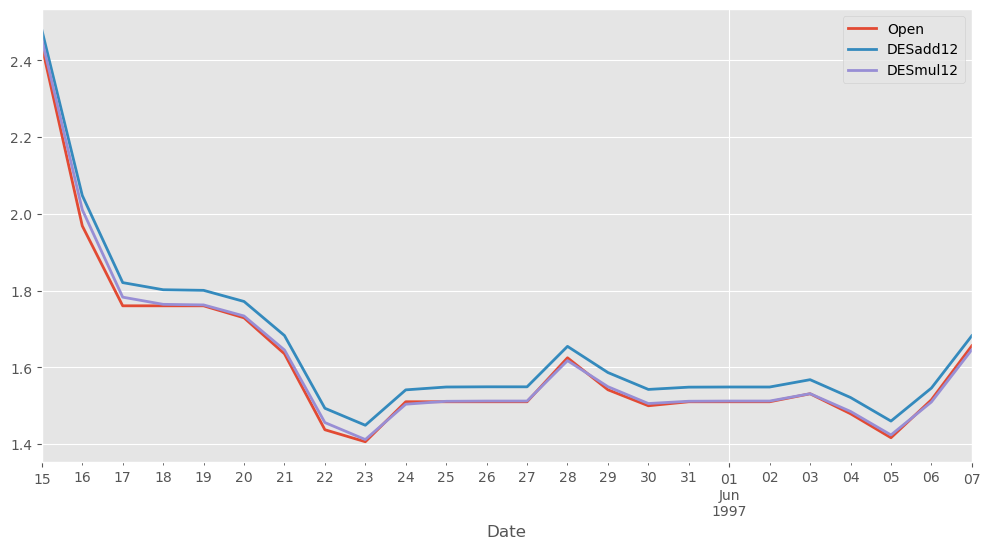

In [70]:
df[['Open','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [71]:
df['TESadd12'] = ExponentialSmoothing(df['Open'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Date,,,,,,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0,7.215601e+07,NaN,NaN,NaN,NaN,2.437500,2.437500,2.479330,2.454320,1.950980
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0,1.470001e+07,-0.796275,NaN,NaN,2.203125,2.365385,2.365385,2.047903,2.010818,2.367713
1997-05-17,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,-0.584571,NaN,NaN,1.864583,2.272313,2.272313,1.820880,1.782960,1.139208
1997-05-18,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.193559,2.193559,1.802316,1.764273,1.916509
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.126922,2.126922,1.800725,1.762741,2.090672


In [72]:
df['TESmul12'] = ExponentialSmoothing(df['Open'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:895: RuntimeWarning: overflow encountered in multiply
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:899: RuntimeWarning: overflow encountered in multiply
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:897: RuntimeWarning: invalid value encountered in true_divide
  b[i] = (beta * detrend(lvls[i], lvls[i - 1])) + \
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:907: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Date,,,,,,,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0,7.215601e+07,NaN,NaN,NaN,NaN,2.437500,2.437500,2.479330,2.454320,1.950980,2.415346
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0,1.470001e+07,-0.796275,NaN,NaN,2.203125,2.365385,2.365385,2.047903,2.010818,2.367713,1.945077
1997-05-17,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,-0.584571,NaN,NaN,1.864583,2.272313,2.272313,1.820880,1.782960,1.139208,1.740763
1997-05-18,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.193559,2.193559,1.802316,1.764273,1.916509,1.745478
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0,6.106809e+06,0.000000,NaN,NaN,1.760417,2.126922,2.126922,1.800725,1.762741,2.090672,1.750937


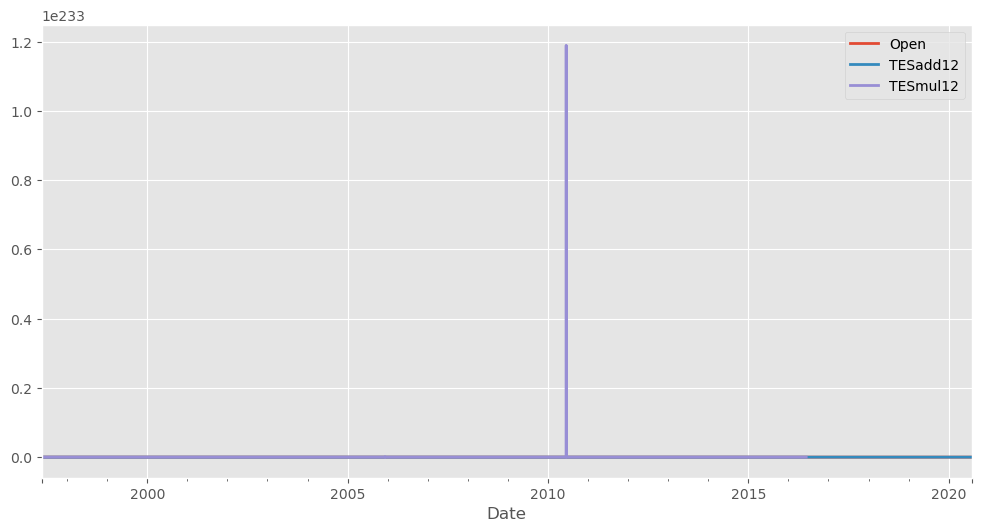

In [73]:
df[['Open','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


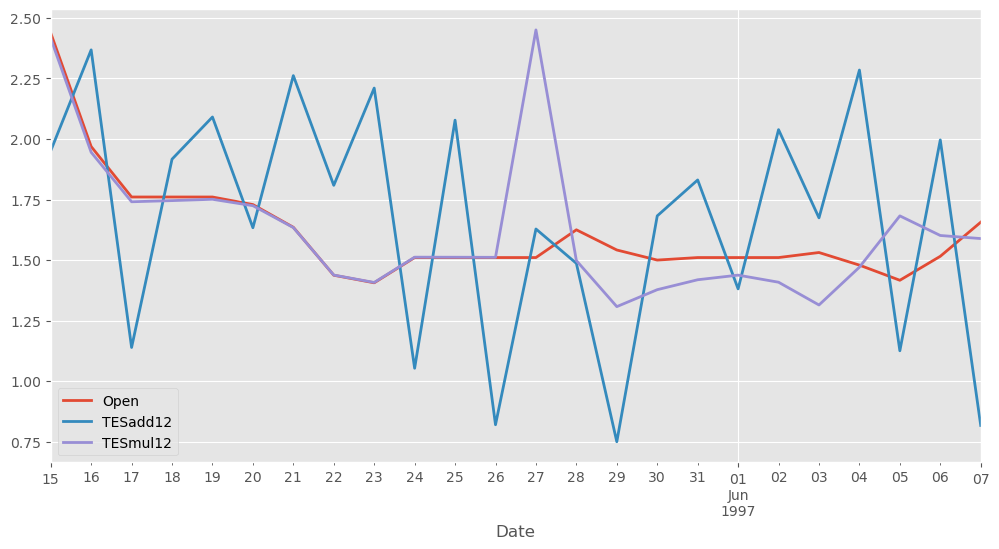

In [74]:
df[['Open','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

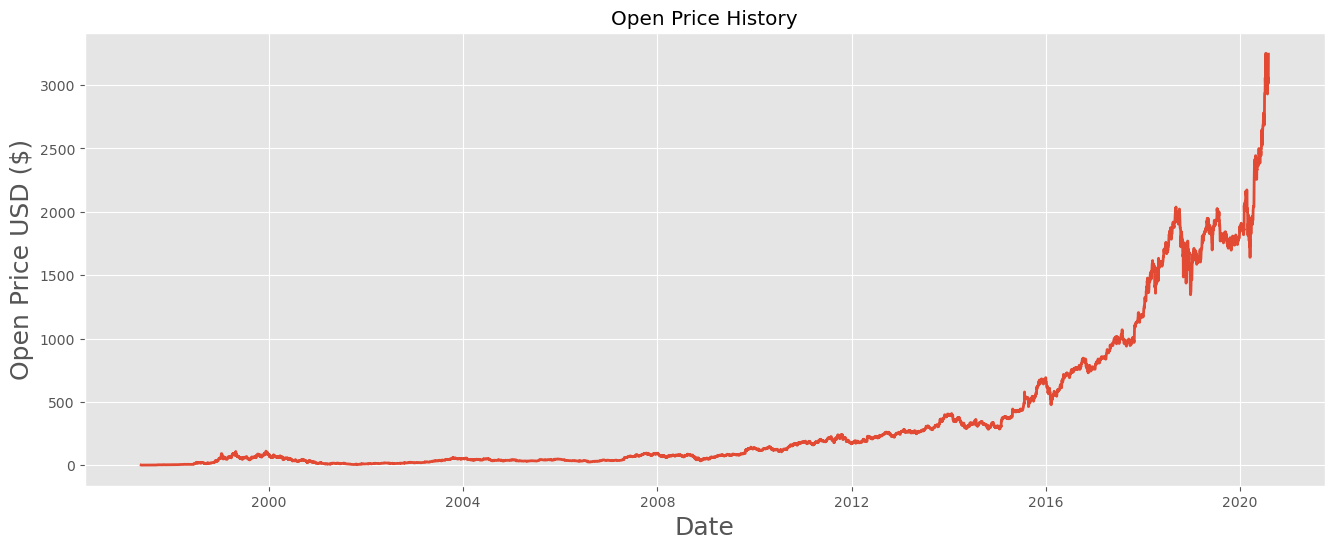

In [75]:
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# LSTM MODEL 

In [76]:

data = df.filter(['Open'])

dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

8056

In [77]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[3.17341496e-04],
       [1.73095361e-04],
       [1.08985956e-04],
       ...,
       [9.32278919e-01],
       [9.27050673e-01],
       [9.97827443e-01]])

In [78]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:

        print()
        

x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [79]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))

In [80]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [81]:
callbacks = [EarlyStopping(patience=4, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]  

In [82]:
history =model.fit(x_train, y_train, 
                        epochs=20,
                        batch_size=1,
                        callbacks=callbacks,
                        )

Epoch 1/20
7996/7996 [==============================] - 37s 5ms/step - loss: 3.5752e-04
Epoch 2/20
7996/7996 [==============================] - 37s 5ms/step - loss: 1.5575e-04
Epoch 3/20
7996/7996 [==============================] - 37s 5ms/step - loss: 9.3226e-05
Epoch 4/20
7996/7996 [==============================] - 37s 5ms/step - loss: 6.6653e-05
Epoch 5/20
7996/7996 [==============================] - 37s 5ms/step - loss: 5.2894e-05
Epoch 6/20
7996/7996 [==============================] - 37s 5ms/step - loss: 4.5059e-05
Epoch 7/20
7996/7996 [==============================] - 37s 5ms/step - loss: 4.5419e-05
Epoch 8/20
7996/7996 [==============================] - 37s 5ms/step - loss: 4.3452e-05
Epoch 9/20
7996/7996 [==============================] - 37s 5ms/step - loss: 4.1721e-05
Epoch 10/20
7996/7996 [==============================] - 37s 5ms/step - loss: 3.5750e-05
Epoch 11/20
7996/7996 [==============================] - 37s 5ms/step - loss: 3.3792e-05
Epoch 12/20
7996/7996 [=======

In [83]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

86.93969449009177

In [84]:
mean_absolute_error(y_test, predictions)


48.74285239361702

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


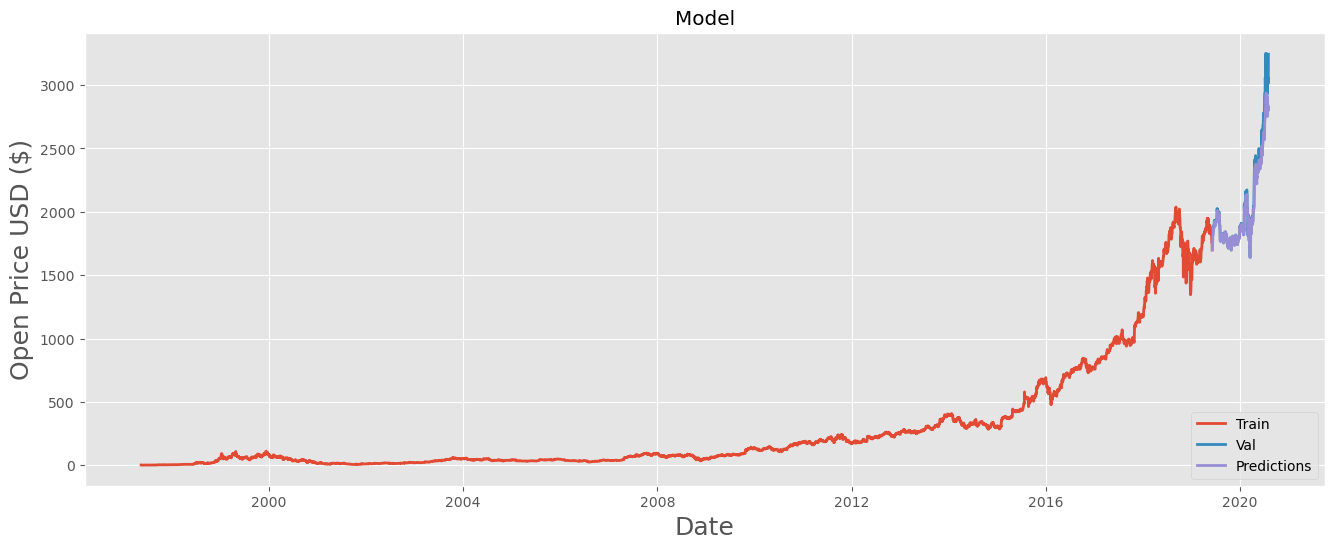

In [85]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [86]:
predictions = model.predict(x_test)


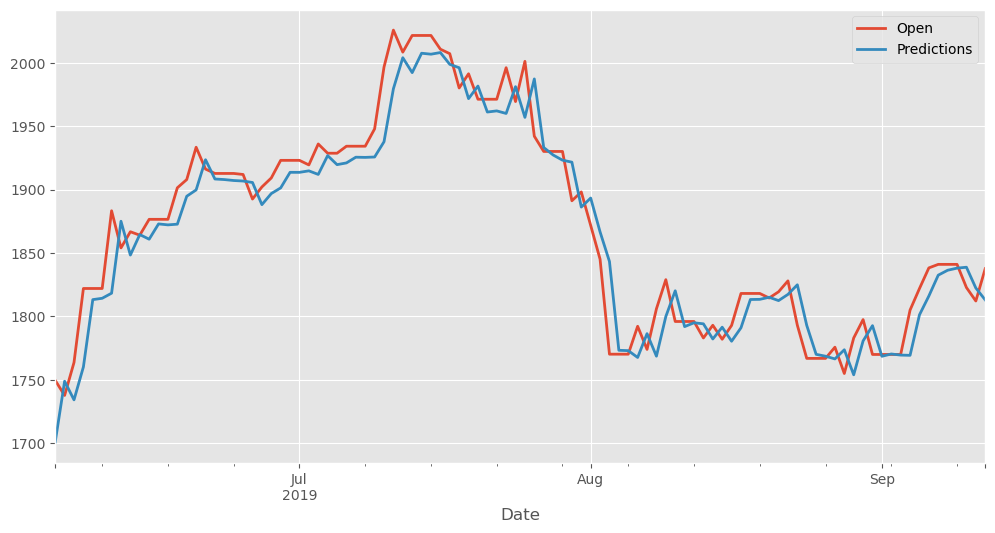

In [87]:
valid[['Open','Predictions']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [88]:
valid


,Open,Predictions
Date,,
2019-06-05,1749.599976,1701.067017
2019-06-06,1737.709961,1748.893677
2019-06-07,1763.699951,1734.227295
2019-06-08,1822.000000,1760.200317
2019-06-09,1822.000000,1813.220337
...,...,...
2020-07-27,3062.000000,2808.044922
2020-07-28,3054.270020,2833.440430
2020-07-29,3030.989990,2820.214111
